In [97]:
using Gen, Plots, Images, Colors

In [98]:
# Global vars
IMG_SIZE = 100;

## Rendering of a scene

In [38]:
# Drawing utilities

# colors
color_map = Dict("red" => (1.0, 0.0, 0.0), "yellow" => (1.0, 1.0, 0.0), "green" => (0.0, 1.0, 0.0))

# shapes
function draw_square!(img, center, size, color)
    x, y = center
    half_size = size ÷ 2
    for dx in -half_size:half_size, dy in -half_size:half_size
        nx, ny = x + dx, y + dy
        if 1 <= nx <= IMG_SIZE && 1 <= ny <= IMG_SIZE
            img[ny, nx] = color
        end
    end
end

# Function to draw a circle
function draw_circle!(img, center, radius, color)
    x, y = center
    for dx in -radius:radius, dy in -radius:radius
        if dx^2 + dy^2 <= radius^2
            nx, ny = x + dx, y + dy
            if 1 <= nx <= IMG_SIZE && 1 <= ny <= IMG_SIZE
                img[ny, nx] = color
            end
        end
    end
end

shape_map = Dict("square" => draw_square!, "circle" => draw_circle!, "star" => draw_square!)

Dict{String, Function} with 3 entries:
  "circle" => draw_circle!
  "star"   => draw_square!
  "square" => draw_square!

In [39]:
function to_display_img(img_matrix)
    return [RGB(img_matrix[i, j]...) for i in 1:IMG_SIZE, j in 1:IMG_SIZE]
end

function render(objects, show_img=false)
    img = fill((1.0,1.0,1.0), IMG_SIZE, IMG_SIZE)
    for (shape, color, center) in objects
        shape_map[shape](img, center, 10, color_map[color])
    end
    if show_img
        display(to_display_img(img))
    end
    return img
    end

function render_trace(trace, show_img=false)
    objects = get_retval(trace)
    render(objects, show_img)
    end

render_trace (generic function with 2 methods)

## Generative model for a scene

In [99]:
# See if should be static compiled for inference efficiency
@gen function scene()
    # Defining how many objects are in the scene
    n_objects ~ poisson(3)
    n_objects += 1 # Making sure at least 1 object

    shape_universe = ["square", "circle", "star"]
    color_universe = ["red", "yellow", "green"]

    # Should probably make this a passed in param
    
    objects = []
    for i = 1:n_objects

        shape_idx = {(:shape, i)} ~ uniform_discrete(1,3)
        shape = shape_universe[shape_idx]

        color_idx = {(:color, i)} ~ uniform_discrete(1,3)
        color = color_universe[color_idx]

        x = {(:x, i)} ~ uniform_discrete(1, IMG_SIZE)
        y = {(:y, i)} ~ uniform_discrete(1, IMG_SIZE)
        
        push!(objects, (shape, color, (x, y)))
    end
    
    return objects
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##scene#305", Bool[], false)

In [100]:
# Generative for scoring
@gen function render_model()
    latents ~ scene()
    x = render(latents)
    obs ~ obs_mixture(x)
    return nothing
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##render_model#306", Bool[], false)

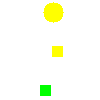

In [104]:
# Example usage
render_trace(Gen.simulate(scene, ()), true);

## Scoring sampled scenes

In [111]:
# Image observation distribution
struct ObservationMixture <: Distribution{Matrix{Tuple{Float64, Float64, Float64}}} end

function Gen.random(::ObservationMixture, X::Matrix{Tuple{Float64, Float64, Float64}})
    # Throw an error since just a scoring fn
    return X
end

function Gen.logpdf(::ObservationMixture,
        Y::Matrix{Tuple{Float64, Float64, Float64}},
        X::Matrix{Tuple{Float64, Float64, Float64}})

    blank = fill((1.0,1.0,1.0), size(X))
    obs_non_background = .!(Y .== blank)
    input_non_background = .!(X .== blank)

    intersection = sum(obs_non_background .& input_non_background)
    normalizer = sum(input_non_background)

    return log(intersection) - log(normalizer)
end

(o::ObservationMixture)(arg) = Gen.random(o, arg)
# (o::ObservationMixture).logpdf(args...) = Gen.logpdf(o, args)

In [121]:
obs_mixture = ObservationMixture()
foo = render(scene())
_ = obs_mixture(foo)
print("Sanity checking score fn: ", exp(logpdf(obs_mixture, foo, foo)))

Sanity checking score fn: 1.0

## Inference procedure

In [83]:
# Example inference procedure
function do_inference(model, constraints, num_iter)
    
    # # Create a choice map that maps model addresses (:y, i)
    # # to observed values ys[i]. We leave :slope and :intercept
    # # unconstrained, because we want them to be inferred.
    # observations = Gen.choicemap()
    # for (i, y) in enumerate(ys)
    #     observations[(:y, i)] = y
    # end
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, weight) = Gen.importance_resampling(model, (), constraints, num_iter);
    return trace, weight
end;

In [84]:
obs = render(scene())

100×100 Matrix{Tuple{Float64, Float64, Float64}}:
 (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)  …  (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)
 (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)     (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)
 (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)     (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)
 (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)     (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)
 (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)     (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)
 (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)  …  (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)
 (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)     (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)
 (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)     (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)
 (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)     (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)
 (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)     (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)
 (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)  …  (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)
 (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)     (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)
 (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)     (1.0, 1.0, 1.0)  (1.0, 1.0, 1.0)
 ⋮                         

In [135]:
constraints = Gen.choicemap()
constraints[:obs] = obs
trace, weight = do_inference(render_model, constraints, 50_000);

In [136]:
typeof(get_retval(trace))

Nothing

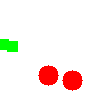

In [137]:
to_display_img(obs)

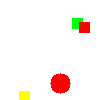

In [138]:
to_display_img(render(trace[:latents]))

In [139]:
trace

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##render_model#306", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:latents => Gen.ChoiceOrCallRecord{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}}(Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##scene#305", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}((:x, 2) => Gen.ChoiceOrCallRecord{Int64}(61, -4.605170185988091, NaN, true), (:y, 3) => Gen.ChoiceOrCallRecord{Int64}(97, -4.605170185988091, NaN, true), (:color, 2) => Gen.ChoiceOrCallRecord{Int64}(1, -1.0986122886681098, NaN, true), (:y, 1) => Gen.ChoiceOrCallRecord{Int64}(24, -4.605170185988091, NaN, true), (:shape, 2) => Gen.ChoiceOrCallRecord{Int64}(2, -1.0986122886681098, NaN, true), (:x, 

In [140]:
weight

-2.4469773242317405